# Importanto as principais bibliotecas

In [ ]:
from google.colab import drive
from google.colab import files
import os
import requests
import json
import random
import scipy.io
import zipfile
#from scipy.io import loadmat

# Defininindo o caminho raiz do Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Montando o drive e definindo o caminho principal para a pasta em que está a base de dados.

In [ ]:
# Definindo o caminho padrão para a pasta que contém o projeto e a base de dados
# Caso dê erro neste ponto, por gentileza, me informar, para que
# eu possa compartilhar corretamente a pasta.

BASE_DIR = '/content/drive/MyDrive/ITA - Pessoal/8º Semestre/ET-287/Projetos/Projeto 4'
os.chdir(BASE_DIR)
os.listdir(BASE_DIR)

['Cars',
 'Drones',
 'People',
 'best_cnn.keras',
 'Project4_Ulisses_Lopes_da_Silva.ipynb']

# Extraindo os arquivos da base de dados.

In [ ]:
# APENAS DESCOMENTE ESTA LINHA E RODE ESTA CÉLULA SE OS ARQUIVOS AINDA NÃO ESTIVEREM DESCOMPACTADOS!
# APÓS A DESCOMPACTAÇÃO, COMENTAR AS LINHAS ABAIXO

# Descompactar os arquivos
# O arquivo é muito grande. Pode demorar um tempo considerável
#zip_object = zipfile.ZipFile(BASE_DIR + '/archive.zip', mode = 'r')
#zip_object.extractall(BASE_DIR)
#zip_object.close()

In [ ]:
os.listdir(BASE_DIR)

['Cars',
 'Drones',
 'People',
 'best_cnn.keras',
 'Project4_Ulisses_Lopes_da_Silva.ipynb']

# **ITEM 3** - Definindo os conjuntos de treino, teste e validação

Para evitar "data leakage", dividiremos os experimentos antes de empilhar os frames. Como há números variados de frames por experimento, iremos colocar nos conjuntos de teste e validação as pastas até completar 10% do total de amostras, para cada uma. Assim, os dados estarão aproximadamente distribuídos da forma mais próxima possível do valor esperado. As demais amostras irão para o treino.

## Pré-processamento dos dados

In [ ]:

# Pré-processamento dos dados
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

CLASSES = ['Cars', 'Drones', 'People']

CLASS_LABELS = {
    'Cars':   [1, 0, 0],
    'Drones': [0, 1, 0],
    'People': [0, 0, 1]
}

# Tamanho do frame
STACK_SIZE = 3

# Parte 1: agrupar dados por experimento

#Esta lista irá guardar "pacotes" de dados, um para cada experimento
#Formato: [ [amostras_exp1, labels_exp1], [amostras_exp2, labels_exp2], ... ]

all_experiments_data = []

# Listas específicas para cada classe
cars, drones, people = [], [], []

print("Iniciando carregamento de dados por experimento...")

for class_name in CLASSES:
    CLASS_PATH = os.path.join(BASE_DIR, class_name)
    class_label = CLASS_LABELS[class_name]

    for experiment in os.listdir(CLASS_PATH):
        experiment_path = os.path.join(CLASS_PATH, experiment)

        csv_files = sorted([f for f in os.listdir(experiment_path) if f.endswith('.csv')])

        # Listas para guardar TODAS as amostras deste ÚNICO experimento
        experiment_samples_X = []
        experiment_samples_y = []

        for i in range(len(csv_files) - STACK_SIZE + 1):
            frames_to_stack = []

            for j in range(STACK_SIZE):
                    csv_path = os.path.join(experiment_path, csv_files[i + j])
                    df = pd.read_csv(csv_path, header=None)
                    frames_to_stack.append(df.to_numpy())

            # Empilha os 3 frames (11, 61, 3)
            stacked_array = np.stack(frames_to_stack, axis=-1)

            # Adiciona às listas *deste* experimento
            experiment_samples_X.append(stacked_array)
            experiment_samples_y.append(class_label)

            # Adiciona às listas específicas da classe
            if class_name == 'Cars': cars.append(stacked_array)
            elif class_name == 'Drones': drones.append(stacked_array)
            elif class_name == 'People': people.append(stacked_array)

        all_experiments_data.append({
            'class': class_name,
            'X_data': experiment_samples_X,
            'y_data': experiment_samples_y
        })

print("Carregamento de dados finalizado.")
print(f"Total de experimentos processados: {len(all_experiments_data)}")

Iniciando carregamento de dados por experimento...
Carregamento de dados finalizado.
Total de experimentos processados: 80


## Estatísticas das amostras

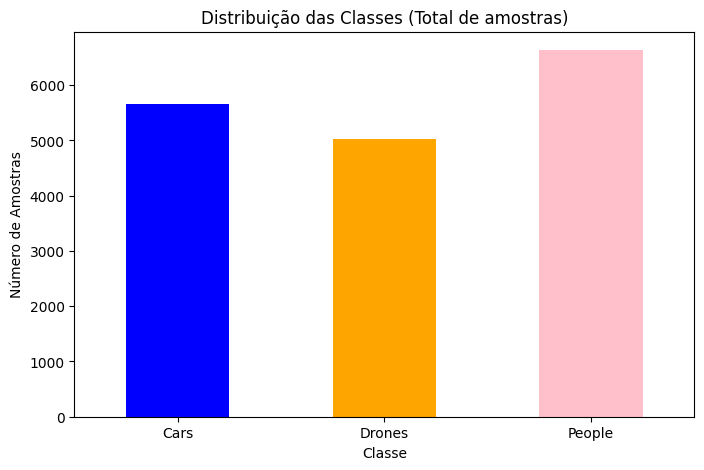

Amostras de carros: 5666
Amostras de drones: 5023
Amostras de pessoas: 6636


In [ ]:
# Amostras por classe
count_cars = len(cars)
count_drones = len(drones)
count_people = len(people)
classes_count = [count_cars, count_drones, count_people]

# Gráfico para melhor visualização
class_counts = pd.Series(classes_count, index=CLASSES)
plt.figure(figsize=(8,5))
plt.title("Distribuição das Classes (Total de amostras)")
class_counts.plot(kind='bar', color=['blue', 'orange', 'pink'])
plt.xlabel('Classe')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=0)
plt.show()

print(f"Amostras de carros: {count_cars}")
print(f"Amostras de drones: {count_drones}")
print(f"Amostras de pessoas: {count_people}")


Podemos notar que os dados estão relativamente bem distribuídos.

In [ ]:
# Parte 2: Divisão proporcional dos experimentos

# Proporções desejadaspara teste e validação. O restante será treino
TEST_SIZE = 0.10
VAL_SIZE = 0.10

# Listas finais para os conjuntos de dados
X_train, y_train = [], []
X_test, y_test = [], []
X_val, y_val = [], []

# Contadores de amostras totais por classe
total_samples_by_class = {name: len(globals()[name.lower()]) for name in CLASSES}
total_samples = sum(total_samples_by_class.values())

# Divisão das amostras nos conjuntos de treino, validação e teste.

In [ ]:
print(f"\nIniciando divisão dos dados... Total de amostras (frames): {total_samples}")

# Itera sobre cada CLASSE para fazer a divisão estratificada
for class_name in CLASSES:

    # Filtra os experimentos apenas desta classe
    class_experiments = [exp for exp in all_experiments_data if exp['class'] == class_name]

    # Embaralha a ORDEM dos experimentos (crucial!)
    random.shuffle(class_experiments)

    # Define os tamanhos de alvo (em número de amostras)
    target_test_count = total_samples_by_class[class_name] * TEST_SIZE
    target_val_count = total_samples_by_class[class_name] * VAL_SIZE

    # Contadores de quantas amostras já foram adicionadas
    current_test_count = 0
    current_val_count = 0

    # Distribui os experimentos
    for exp_data in class_experiments:
        num_samples_in_exp = len(exp_data['X_data'])

        # 1. Preenche o conjunto de TESTE primeiro
        if current_test_count < target_test_count:
            X_test.extend(exp_data['X_data'])
            y_test.extend(exp_data['y_data'])
            current_test_count += num_samples_in_exp

        # 2. Preenche o conjunto de VALIDAÇÃO
        elif current_val_count < target_val_count:
            X_val.extend(exp_data['X_data'])
            y_val.extend(exp_data['y_data'])
            current_val_count += num_samples_in_exp

        # 3. O que sobrar vai para o TREINO
        else:
            X_train.extend(exp_data['X_data'])
            y_train.extend(exp_data['y_data'])

print("Divisão finalizada.")


Iniciando divisão dos dados... Total de amostras (frames): 17325
Divisão finalizada.


## Normalizando e verificando o formato final dos dados

In [ ]:
# Parte 3: Conversão final e normalização dos dados
from sklearn.preprocessing import StandardScaler

# Converter as listas para arrays NumPy
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# Inicializar o Scaler
scaler = StandardScaler()

# Preparr os dados para o Scaler (dados 2D)
# Guarda os shapes originais
train_shape = X_train.shape
val_shape = X_val.shape
test_shape = X_test.shape

# Reformatar de (N, 11, 61, 3) para (N, 11*61*3)
X_train_2d = X_train.reshape(train_shape[0], -1)
X_val_2d = X_val.reshape(val_shape[0], -1)
X_test_2d = X_test.reshape(test_shape[0], -1)

# Aplicar o módulo ANTES de normalizar
# Isso garante que estamos normalizando as magnitudes (valores positivos)
X_train_2d = np.absolute(X_train_2d)
X_val_2d = np.absolute(X_val_2d)
X_test_2d = np.absolute(X_test_2d)

# Normalização
# Calcula a média e o desvio nos dados de TREINO
print("Calculando média e desvio padrão do conjunto de treino...")
scaler.fit(X_train_2d)

# Aplica a transformação em TODOS os conjuntos
print("Normalizando conjuntos de treino, validação e teste...")
X_train_scaled = scaler.transform(X_train_2d)
X_val_scaled = scaler.transform(X_val_2d)
X_test_scaled = scaler.transform(X_test_2d)

# Volta os dados para o shape 4D original (input da CNN)
X_train = X_train_scaled.reshape(train_shape)
X_val = X_val_scaled.reshape(val_shape)
X_test = X_test_scaled.reshape(test_shape)

print("Normalização concluída.")


Calculando média e desvio padrão do conjunto de treino...
Normalizando conjuntos de treino, validação e teste...
Normalização concluída.


In [ ]:
# Parte 4: Verificação dos Resultados

print("\n--- Shapes dos Conjuntos ---")
print(f"X_train shape: {X_train.shape}") # (N_train, 11, 61, 3)
print(f"y_train shape: {y_train.shape}") # (N_train, 3)

print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Verifica as proporções
total_final = len(y_train) + len(y_val) + len(y_test)
print(f"\n--- Proporções Finais (baseado em {total_final} amostras) ---")
print(f"Treino: {len(y_train)} amostras (~{len(y_train)/total_final*100:.1f}%)")
print(f"Validação: {len(y_val)} amostras (~{len(y_val)/total_final*100:.1f}%)")
print(f"Teste: {len(y_test)} amostras (~{len(y_test)/total_final*100:.1f}%)")


--- Shapes dos Conjuntos ---
X_train shape: (13084, 11, 61, 3)
y_train shape: (13084, 3)
X_val shape: (2076, 11, 61, 3)
y_val shape: (2076, 3)
X_test shape: (2165, 11, 61, 3)
y_test shape: (2165, 3)

--- Proporções Finais (baseado em 17325 amostras) ---
Treino: 13084 amostras (~75.5%)
Validação: 2076 amostras (~12.0%)
Teste: 2165 amostras (~12.5%)


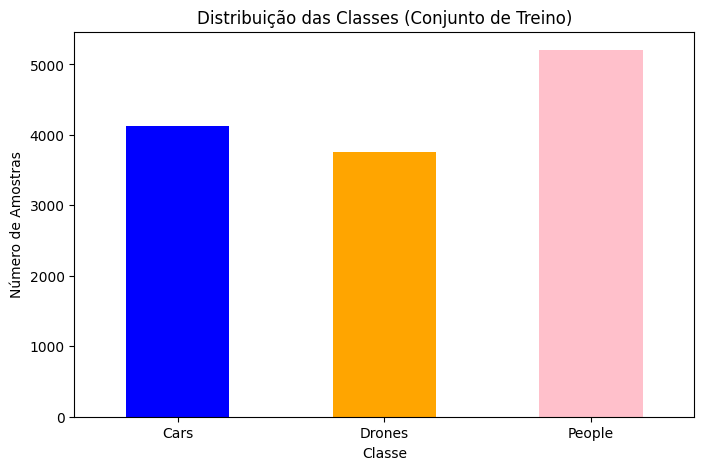

Conjunto de TREINAMENTO:
----Amostras de carros: 4127
----Amostras de drones: 3753
----Amostras de pessoas: 5204


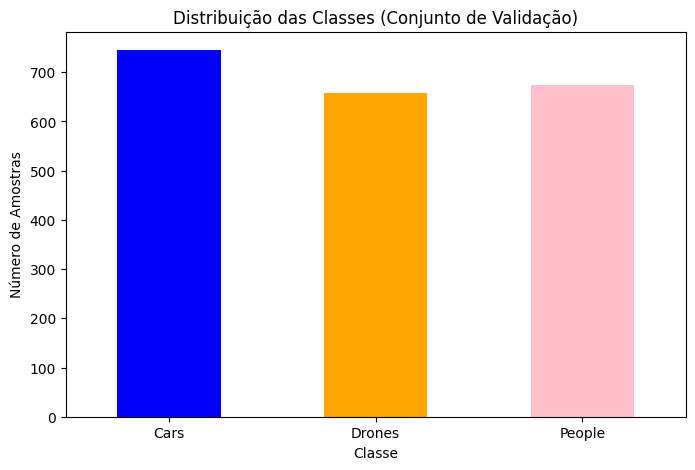

Conjunto de VALIDAÇÃO:
----Amostras de carros: 745
----Amostras de drones: 658
----Amostras de pessoas: 673


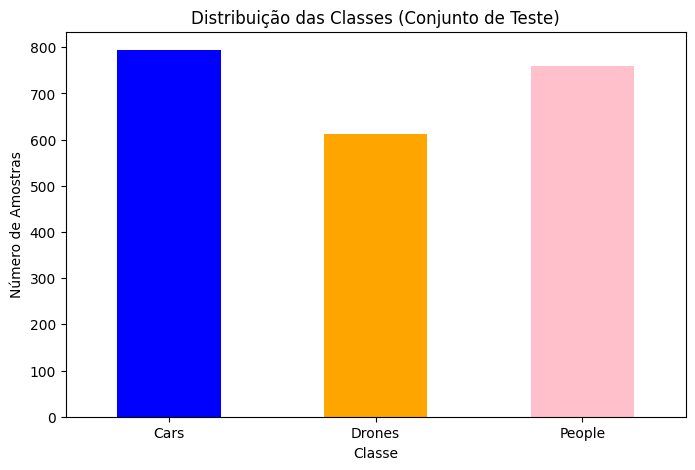

Conjunto de TESTE:
----Amostras de carros: 794
----Amostras de drones: 612
----Amostras de pessoas: 759


In [ ]:
# Gráfico da divisão das amostras pelos conjuntos de treino, teste e validação
# Treinamento
train_counts_array = np.sum(y_train, axis=0)
train_class_counts = pd.Series(train_counts_array, index=CLASSES)
plt.figure(figsize=(8,5))
plt.title("Distribuição das Classes (Conjunto de Treino)")
train_class_counts.plot(kind='bar', color=['blue', 'orange', 'pink'])
plt.xlabel('Classe')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=0)
plt.show()
print("Conjunto de TREINAMENTO:")
print(f"----Amostras de carros: {train_counts_array[0]}")
print(f"----Amostras de drones: {train_counts_array[1]}")
print(f"----Amostras de pessoas: {train_counts_array[2]}")


# Validação
val_counts_array = np.sum(y_val, axis=0)
val_class_counts = pd.Series(val_counts_array, index=CLASSES)
plt.figure(figsize=(8,5))
plt.title("Distribuição das Classes (Conjunto de Validação)")
val_class_counts.plot(kind='bar', color=['blue', 'orange', 'pink'])
plt.xlabel('Classe')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=0)
plt.show()
print("Conjunto de VALIDAÇÃO:")
print(f"----Amostras de carros: {val_counts_array[0]}")
print(f"----Amostras de drones: {val_counts_array[1]}")
print(f"----Amostras de pessoas: {val_counts_array[2]}")


# Teste
test_counts_array = np.sum(y_test, axis=0)
test_class_counts = pd.Series(test_counts_array, index=CLASSES)
plt.figure(figsize=(8,5))
plt.title("Distribuição das Classes (Conjunto de Teste)")
test_class_counts.plot(kind='bar', color=['blue', 'orange', 'pink'])
plt.xlabel('Classe')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=0)
plt.show()
print("Conjunto de TESTE:")
print(f"----Amostras de carros: {test_counts_array[0]}")
print(f"----Amostras de drones: {test_counts_array[1]}")
print(f"----Amostras de pessoas: {test_counts_array[2]}")



É importante ressaltar que, ao iterar sobre o dataset, perde-se algumas amostras, pois as duas últimas amostras de arquivo de cada subpasta não podem ser o início de uma pilha de 3 frames. Contudo, a perda é ínfima (≈ 0.91 %). Não obstante, para evitar o data leakage mantendo a proporcionalidade do número de amostras, os conjuntos de teste, validação e treino podem não corresponder, exatamente, a 10/10/80, respectivamente, mas estão próximos.

# **ITEM 4** - Implementação da CNN

In [ ]:
# Importando os principais recursos
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, ReLU,Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight

## Configurando alguns parâmetros da rede e de treinamento

In [ ]:
num_classes = 3
num_epochs = 100
input_shape = (11, 61, 3)

In [ ]:

# Parâmetros de treinamento
opt = Adam(learning_rate=0.0001)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
metrics = ['accuracy']
l2_rate = 0.001

# Parâmetros de Callback
es = EarlyStopping(monitor='val_loss',
                   patience=15,
                   verbose=1,
                   restore_best_weights=True
)

rlrp = ReduceLROnPlateau(monitor='val_loss',
                         factor=0.5,
                         patience=10,
                         verbose=1,
                         min_lr = 1e-6
)

mcheckp = ModelCheckpoint('best_cnn.keras',
                          monitor='val_loss',
                          save_best_only=True,
                          verbose=1
)

In [ ]:
###### MODELO PRIORITÁRIO!! NÃO APAGAR ######

# Criando a rede neural
model = Sequential()

# bloco 1
model.add(Conv2D(filters=112, kernel_size=(3,3), padding='valid', kernel_initializer='he_normal',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))

# bloco 2
model.add(Flatten())

# bloco 3
model.add(Dense(units=64, kernel_initializer='he_normal', kernel_regularizer=l2(l2_rate)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# bloco 4
model.add(Dense(units=64, kernel_initializer='he_normal', kernel_regularizer=l2(l2_rate)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.40))

# bloco 5
model.add(Dense(units=64, kernel_initializer='he_normal', kernel_regularizer=l2(l2_rate)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.40))

# bloco 6
model.add(Dense(units=num_classes, kernel_initializer='he_normal'))
model.add(Activation('softmax'))

print(model.summary())


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 9, 59, 112)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 9, 59, 112)     │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 9, 59, 112)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 59472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │     3,806,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │           195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,819,139 (14.57 MB)

 Trainable params: 3,818,531 (14.57 MB)

 Non-trainable params: 608 (2.38 KB)

None


In [ ]:
# Compilando o modelo de CNN
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [ ]:
# Treinamento da Rede Neural
histoy = model.fit(X_train,
                   y_train,
                   validation_data=(X_val, y_val),
                   epochs=200,
                   batch_size=64,
                   callbacks=[es, rlrp, mcheckp],
                   shuffle=True
)

Epoch 1/200
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4356 - loss: 1.6267
Epoch 1: val_loss improved from inf to 1.03705, saving model to best_cnn.keras
205/205 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.4360 - loss: 1.6257 - val_accuracy: 0.8343 - val_loss: 1.0371 - learning_rate: 1.0000e-04
Epoch 2/200
193/205 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6758 - loss: 1.1386
Epoch 2: val_loss improved from 1.03705 to 0.87601, saving model to best_cnn.keras
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6793 - loss: 1.1347 - val_accuracy: 0.8988 - val_loss: 0.8760 - learning_rate: 1.0000e-04
Epoch 3/200
192/205 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8411 - loss: 0.9313
Epoch 3: val_loss improved from 0.87601 to 0.73757, saving model to best_cnn.keras
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8419 - loss: 0.9297 - val_accuracy: 0.9446 - val_loss: 0.7376 - learning_rate: 1.0000e-04
Epoch 4/200
190/205 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - a

## Plotando gráficos do treinamento

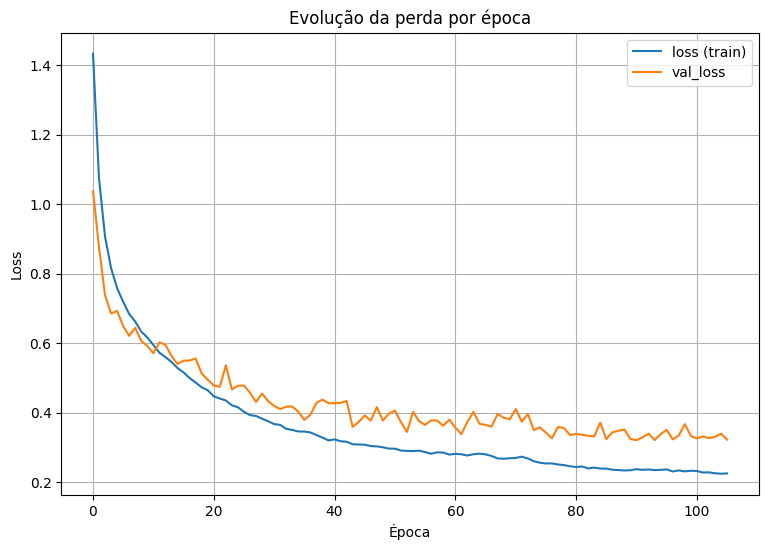

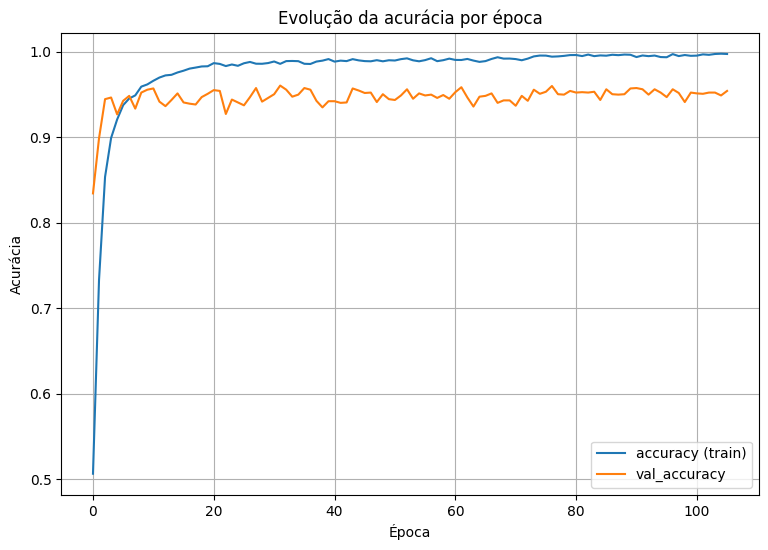

In [ ]:
# Gráfic
plt.figure(figsize=(9,6))
plt.plot(model.history.history['loss'], label='loss (train)')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.title('Evolução da perda por época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de Accuracy
plt.figure(figsize=(9,6))
plt.plot(model.history.history['accuracy'], label='accuracy (train)')
plt.plot(model.history.history['val_accuracy'], label='val_accuracy')
plt.title('Evolução da acurácia por época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

# **ITEM 5** - Avaliação do modelo da rede utilizando o conjunto de **validação**

--- Avaliação no Conjunto de VALIDAÇÃO ---
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9261 - loss: 0.4131

Val_loss: 0.3213 --- Val_acc: 0.9576
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy (val): 0.9576107899807321

Classification Report (Validação):
              precision    recall  f1-score   support

        Cars       0.98      0.93      0.95       745
      Drones       0.91      0.98      0.94       658
      People       0.99      0.97      0.98       673

    accuracy                           0.96      2076
   macro avg       0.96      0.96      0.96      2076
weighted avg       0.96      0.96      0.96      2076


Confusion Matrix (Validação):


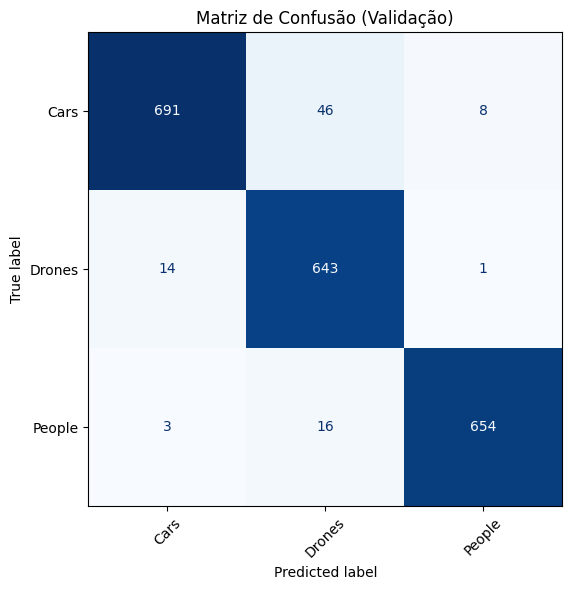

In [ ]:
# Validação do modelo de Rede Neural
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# -----------------------------------------------------------------
#    Validação do Modelo (usando o Conjunto de VALIDAÇÃO)
# ----------------------------------------------------------------
print("--- Avaliação no Conjunto de VALIDAÇÃO ---")

# Avaliação do modelo
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"\nVal_loss: {val_loss:.4f} --- Val_acc: {val_acc:.4f}")

predictions_val = model.predict(X_val)
y_pred = np.argmax(predictions_val, axis=1)
y_true = np.argmax(y_val, axis=1)

# Converte previsões (probabilidades softmax) e rótulos (one-hot) em índices de classe
y_pred_val = np.argmax(predictions_val, axis=1)
y_true_val = np.argmax(y_val, axis=1) # Converte [1,0,0] -> 0

print("Accuracy (val):", accuracy_score(y_true_val, y_pred_val))

# Relatório de Classificação (Precision, Recall, F1-Score)
print("\nClassification Report (Validação):")
print(classification_report(y_true_val, y_pred_val, target_names=CLASSES))

# Matriz de Confusão (Validação)
print("\nConfusion Matrix (Validação):")
cm_val = confusion_matrix(y_true_val, y_pred_val)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=CLASSES)
fig, ax = plt.subplots(figsize=(8,6))
disp_val.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusão (Validação)")
plt.tight_layout()
plt.show()


Resposta.: Avaliando os resultados, o modelo teve um desempenho muito bom, apesar de não ter alcançado os incríveis 99% do modelo do artigo. Os gráficos de treinamento mostram uma evolução muito saudável: a perda (loss) de treino e validação diminui consistentemente, enquanto a acurácia (accuracy) de ambas sobe rapidamente e se estabiliza em um nível alto. A acurácia final no conjunto de validação atingiu 95,8% (Val_acc: 0.9576), o que é um resultado muito robusto.

A única ressalva, contudo, é que os gráficos mostram leves sinais de overfitting: a acurácia de treino (linha azul) é consistentemente mais alta que a de validação (linha laranja), e a perda de treino é menor que a de validação. Isso é normal e indica que o modelo "decorou" os dados de treino um pouco melhor do que consegue generalizar. No entanto, como a acurácia de validação se manteve alta e estável (em ~95%), isso não comprometeu o resultado final. No geral, é um modelo muito bem-sucedido e confiável.

# **ITEM 6** - Analise as métricas de desempenho, como acurácia, precisão, *recall* e *F1-score*, para cada classe (cars, drones, people)

In [ ]:
# Relatório de Classificação (Precision, Recall, F1-Score)
print("\nClassification Report (Validação):")
print(classification_report(y_true_val, y_pred_val, target_names=CLASSES))


Classification Report (Validação):
              precision    recall  f1-score   support

        Cars       0.98      0.93      0.95       745
      Drones       0.91      0.98      0.94       658
      People       0.99      0.97      0.98       673

    accuracy                           0.96      2076
   macro avg       0.96      0.96      0.96      2076
weighted avg       0.96      0.96      0.96      2076



A acurácia geral do modelo é de 96%, o que é um resultado excelente e indica que ele é altamente preciso na maioria das vezes. Analisando cada classe individualmente, vemos alguns comportamentos específicos:

- Classe "Cars" (Carros):

Precisão (Precision): 0.98. Esta é uma métrica muito alta. Significa que, de todas as vezes que o modelo previu "Carro", ele acertou 98% das vezes. É uma previsão muito confiável.

Recall (Revocação): 0.93. Esta é a métrica mais baixa do relatório. Significa que o modelo conseguiu encontrar 93% de todos os carros reais, mas "perdeu" (classificou erroneamente como outra coisa) os 7% restantes.

F1-Score (0.95): Um F1-Score muito alto, mostrando um ótimo equilíbrio geral para esta classe.

- Classe "Drones":

Precisão (Precision): 0.91. Esta é a precisão mais baixa entre as classes. Indica que, quando o modelo prevê "Drone", ele está errado em 9% das vezes, gerando alguns falsos positivos (provavelmente classificando Carros ou Pessoas como Drones).

Recall (Revocação): 0.98. Esta é a métrica de recall mais alta do relatório. Para uma aplicação de segurança, este é o resultado mais importante, pois o modelo é excelente em encontrar drones, identificando corretamente 98% de todos os drones reais e "perdendo" apenas 2%.

F1-Score (0.94): Um F1-Score forte, indicando que, apesar de alguns falsos positivos, o modelo é muito eficaz na tarefa de identificar drones.

- Classe "People" (Pessoas):

Precisão (Precision): 0.99. Desempenho quase perfeito, em que, se o modelo prediz "Pessoa", é praticamente certo que ele está correto.

Recall (Revocação): 0.97. Outra métrica muito boa. O modelo encontra 97% de todas as amostras de "Pessoa".

F1-Score (0.98): O F1-Score mais alto, indicando que esta foi a classe que o modelo aprendeu a identificar com maior facilidade e equilíbrio.

Com relação à classe "Pessoas", os altos índices se devem, provavelmente, ao caráter "instável" dos sinais dessa classe, já que o ser humano produz mais movimento ao andar, correr, etc, ao contrário de drones e carros, que são mais "estáveis". Assim, com sinais mais "característicos", é mais fácil classificar uma amostra como sendo dessa classe.

Em resumo, o modelo é excelente em identificar Pessoas e é satisfatoriamente eficaz em encontrar Drones (recall de 98%), embora às custas de alguns falsos positivos (precisão de 91%). Sua performance mais "fraca" (mas ainda assim, muito boa) é o recall de Carros, indicando que alguns carros estão sendo confundidos com outras classes.

# **ITEM 7** - Visualize as previsões do modelo em amostras de dados de teste para entender melhor suas capacidades e limitações.



--- Avaliação Final no Conjunto de TESTE ---
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9287 - loss: 0.3852

Test_loss: 0.3291 --- Test_acc: 0.9520
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Scikit-learn Accuracy (Teste): 0.9519630484988453

Classification Report (Teste):
              precision    recall  f1-score   support

        Cars       0.96      0.92      0.94       794
      Drones       0.93      0.95      0.94       612
      People       0.96      0.99      0.97       759

    accuracy                           0.95      2165
   macro avg       0.95      0.95      0.95      2165
weighted avg       0.95      0.95      0.95      2165


Confusion Matrix (Teste):


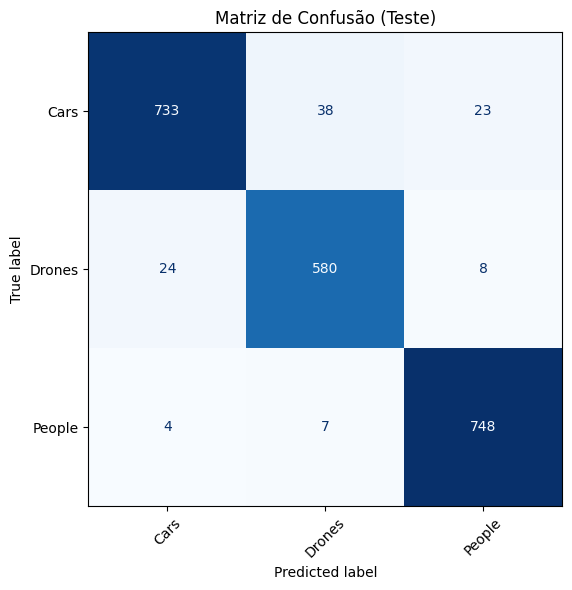


Confusion Matrix Normalizada (Teste):


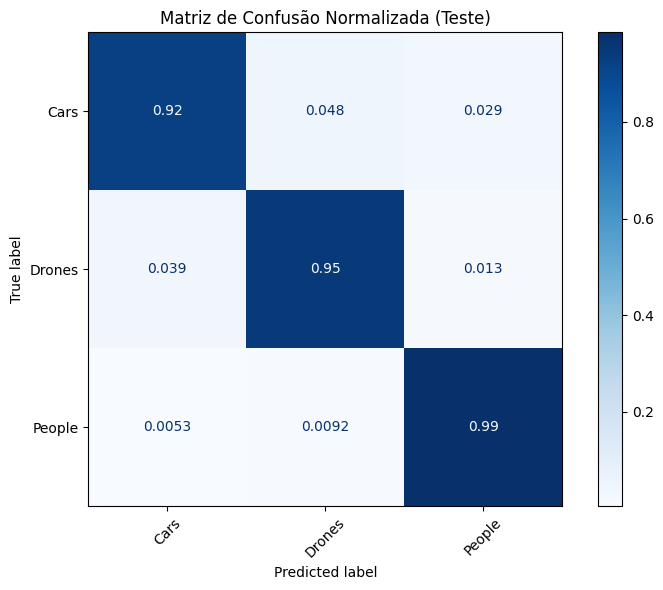

In [ ]:
# -----------------------------------------------------------------
#    Avaliação FINAL (usando o Conjunto de TESTE)
# -----------------------------------------------------------------
print("\n\n" + "="*50)
print("--- Avaliação Final no Conjunto de TESTE ---")

# Avaliação do modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest_loss: {test_loss:.4f} --- Test_acc: {test_acc:.4f}")

# Previsões (do conjunto de TESTE)
predictions_test = model.predict(X_test)

# Converte em índices de classe
y_pred_test = np.argmax(predictions_test, axis=1)
y_true_test = np.argmax(y_test, axis=1)

# Acurácia do modelo
print("Scikit-learn Accuracy (Teste):", accuracy_score(y_true_test, y_pred_test))

# Relatório de Classificação
print("\nClassification Report (Teste):")
print(classification_report(y_true_test, y_pred_test, target_names=CLASSES))

# Matriz de Confusão (Teste)
print("\nConfusion Matrix (Teste):")
cm_test = confusion_matrix(y_true_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=CLASSES)
fig, ax = plt.subplots(figsize=(8,6))
disp_test.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusão (Teste)")
plt.tight_layout()
plt.show()

# Matriz de Confusão Normalizada (Teste)
print("\nConfusion Matrix Normalizada (Teste):")
cm_test_norm = confusion_matrix(y_true_test, y_pred_test, normalize='true')
disp_test_norm = ConfusionMatrixDisplay(confusion_matrix=cm_test_norm, display_labels=CLASSES)
fig, ax = plt.subplots(figsize=(8,6))
# Adicionar cor para a  avaliação final
disp_test_norm.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=True)
plt.title("Matriz de Confusão Normalizada (Teste)")
plt.tight_layout()
plt.show()


--- AMOSTRA DO CONJUNTO DE TESTE #1 (Índice Original: 1100) ---
Classe Verdadeira: Drones
Classe Prevista:   Drones  ---> (CORRETO)
---------------------------------
Confiança do Modelo (Probabilidades):
  - Cars: 1.42%
  - Drones: 97.09%
  - People: 1.49%
---------------------------------


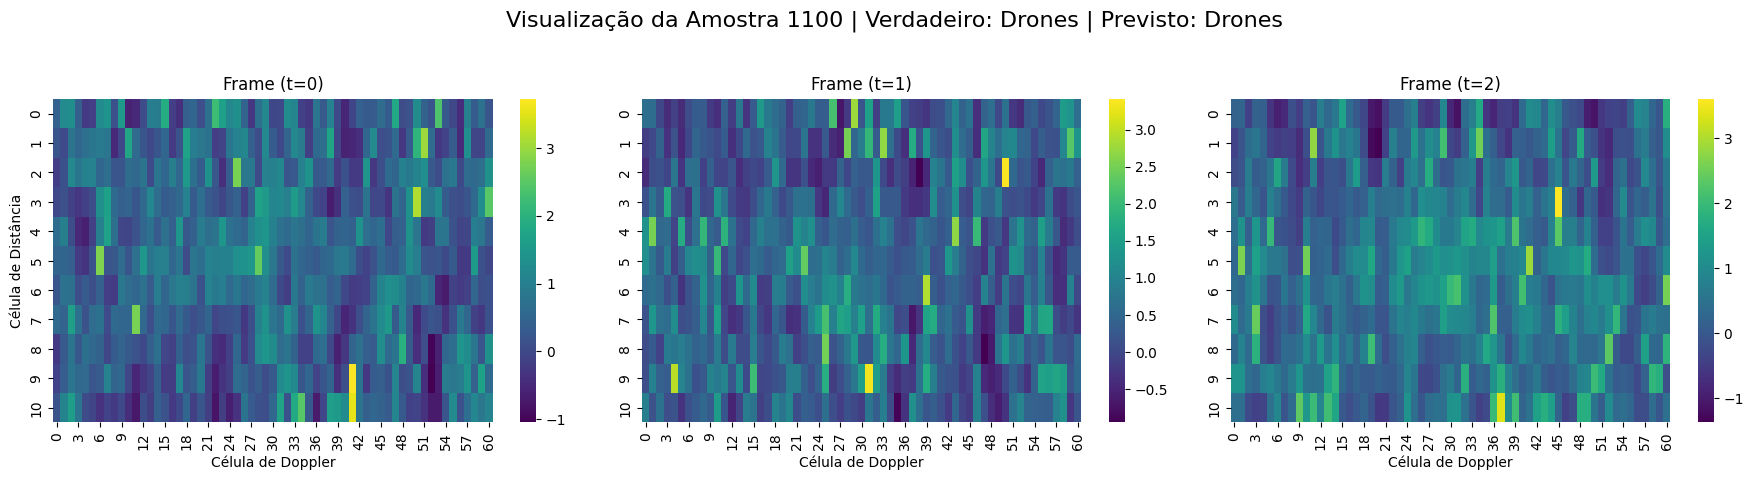



--- AMOSTRA DO CONJUNTO DE TESTE #2 (Índice Original: 1795) ---
Classe Verdadeira: People
Classe Prevista:   People  ---> (CORRETO)
---------------------------------
Confiança do Modelo (Probabilidades):
  - Cars: 1.33%
  - Drones: 1.32%
  - People: 97.35%
---------------------------------


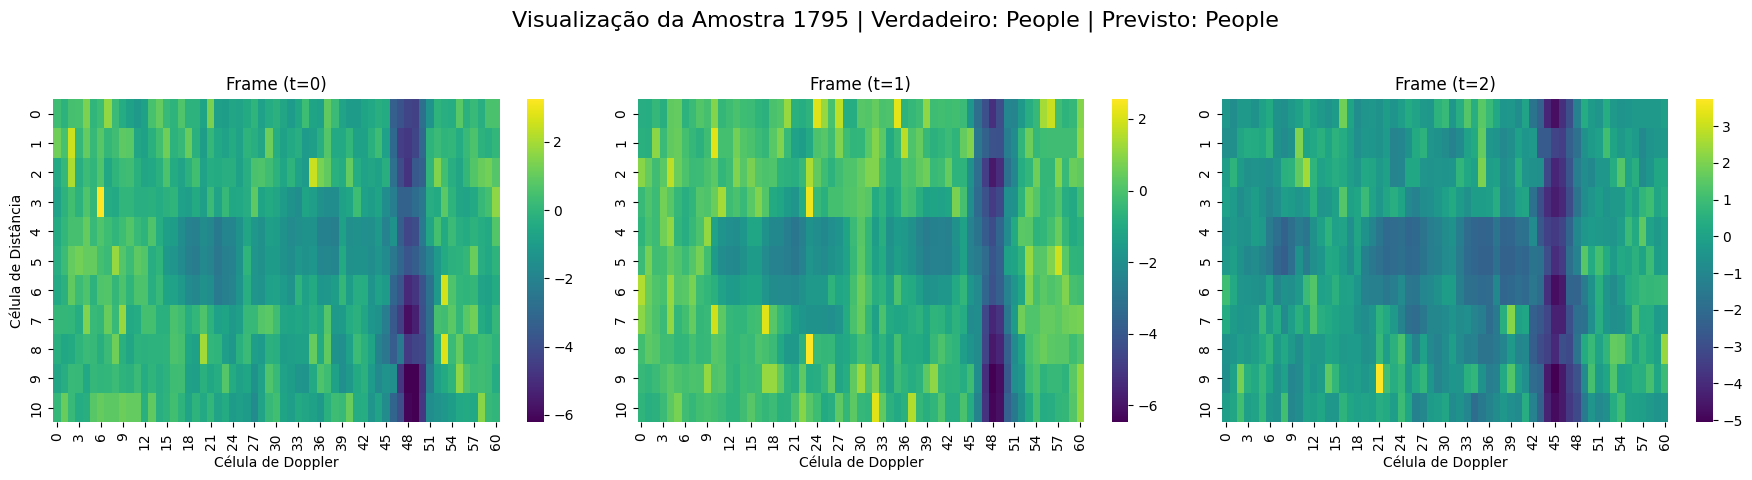



--- AMOSTRA DO CONJUNTO DE TESTE #3 (Índice Original: 2079) ---
Classe Verdadeira: People
Classe Prevista:   People  ---> (CORRETO)
---------------------------------
Confiança do Modelo (Probabilidades):
  - Cars: 1.13%
  - Drones: 1.55%
  - People: 97.32%
---------------------------------


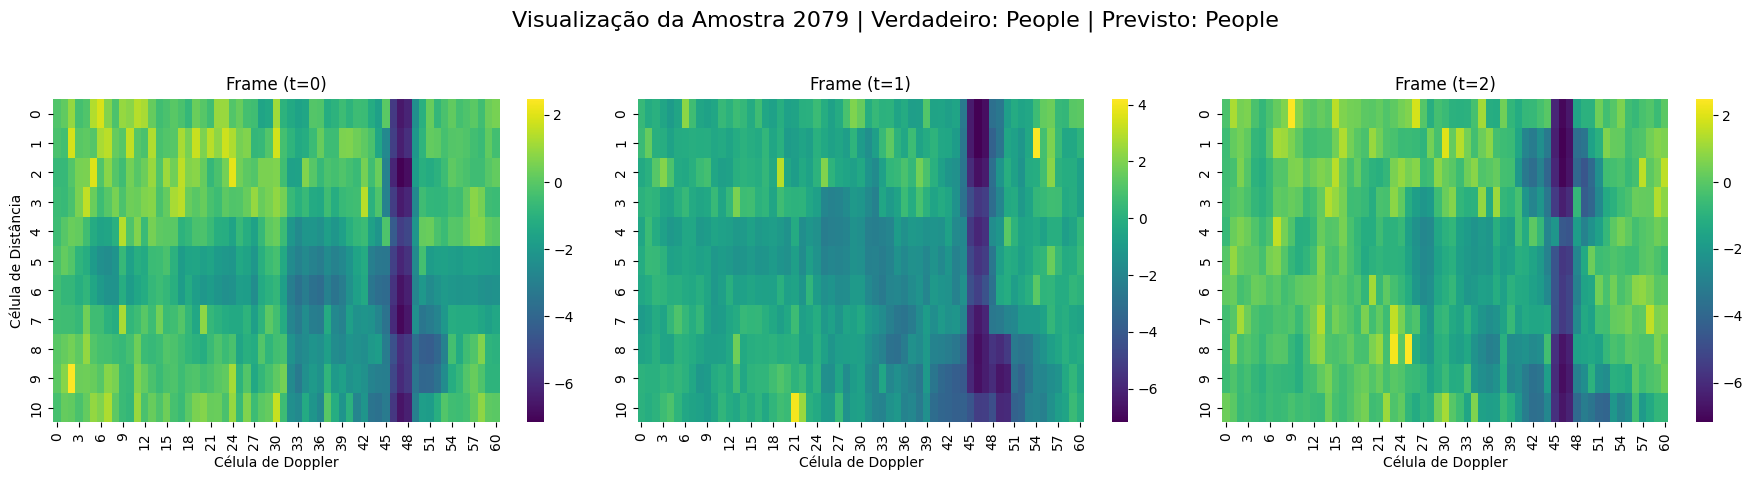



--- AMOSTRA DO CONJUNTO DE TESTE #4 (Índice Original: 193) ---
Classe Verdadeira: Cars
Classe Prevista:   Cars  ---> (CORRETO)
---------------------------------
Confiança do Modelo (Probabilidades):
  - Cars: 97.45%
  - Drones: 1.44%
  - People: 1.10%
---------------------------------


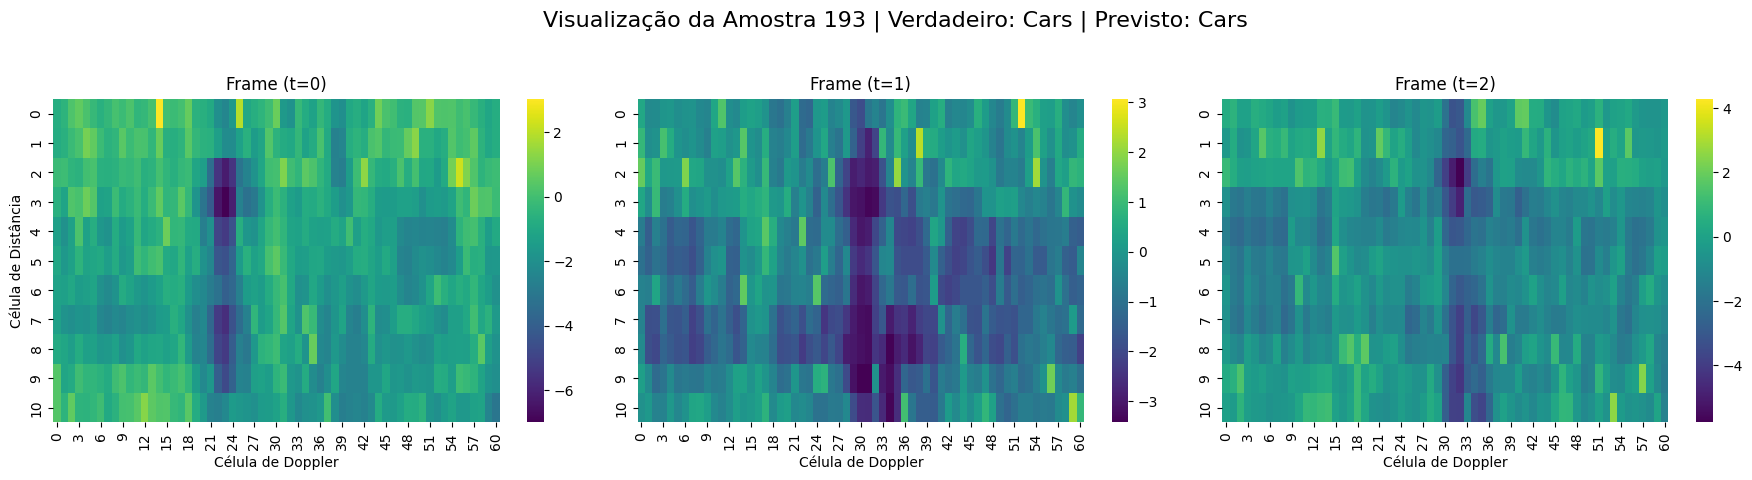



--- AMOSTRA DO CONJUNTO DE TESTE #5 (Índice Original: 2073) ---
Classe Verdadeira: People
Classe Prevista:   People  ---> (CORRETO)
---------------------------------
Confiança do Modelo (Probabilidades):
  - Cars: 1.21%
  - Drones: 1.45%
  - People: 97.33%
---------------------------------


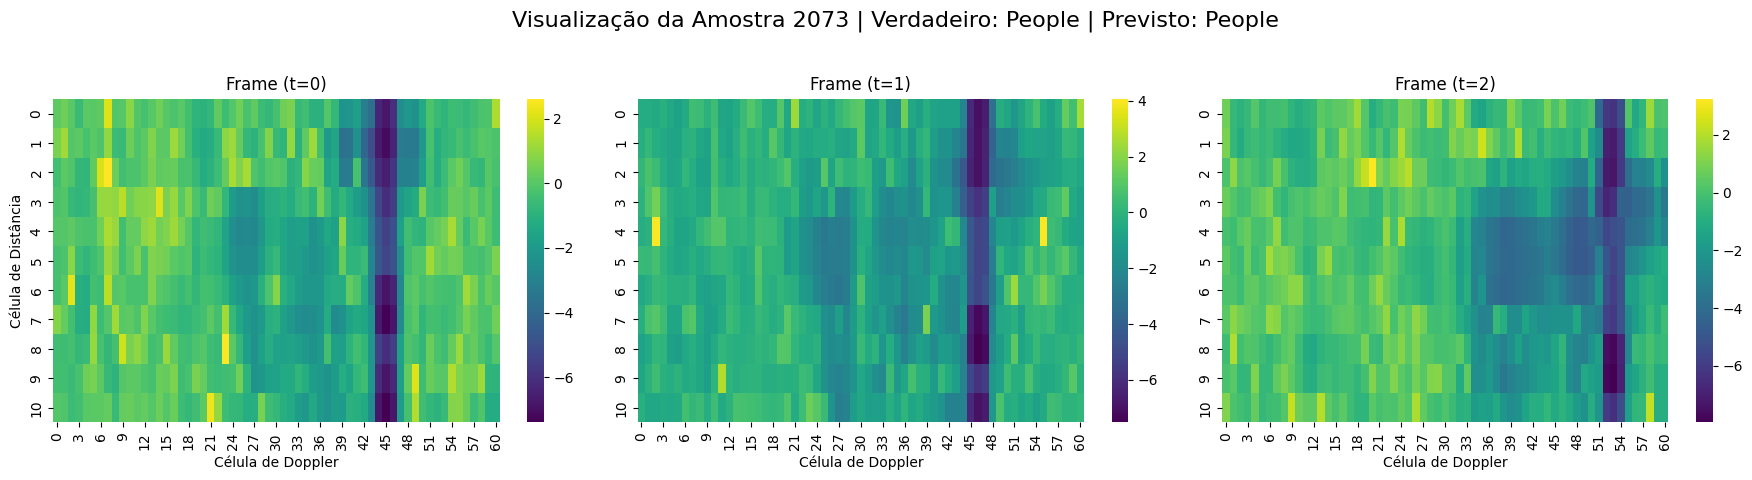



--- AMOSTRA DO CONJUNTO DE TESTE #6 (Índice Original: 2117) ---
Classe Verdadeira: People
Classe Prevista:   People  ---> (CORRETO)
---------------------------------
Confiança do Modelo (Probabilidades):
  - Cars: 1.27%
  - Drones: 1.47%
  - People: 97.26%
---------------------------------


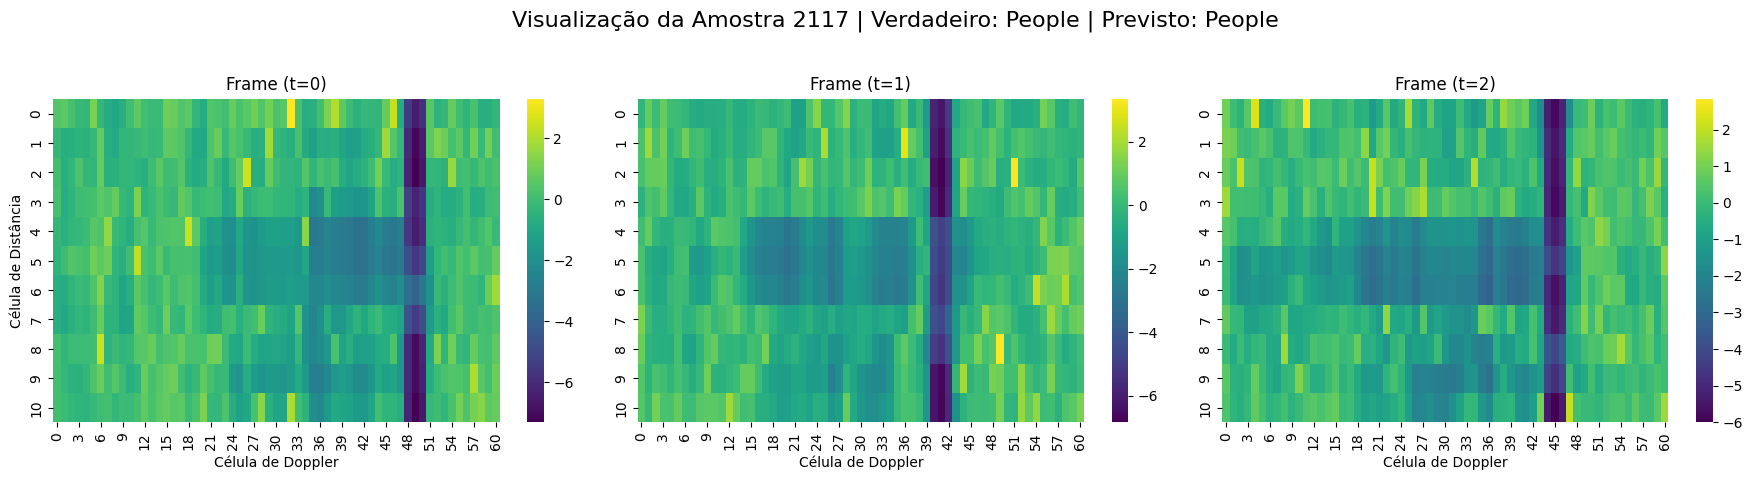



--- AMOSTRA DO CONJUNTO DE TESTE #7 (Índice Original: 1551) ---
Classe Verdadeira: People
Classe Prevista:   People  ---> (CORRETO)
---------------------------------
Confiança do Modelo (Probabilidades):
  - Cars: 1.24%
  - Drones: 1.46%
  - People: 97.30%
---------------------------------


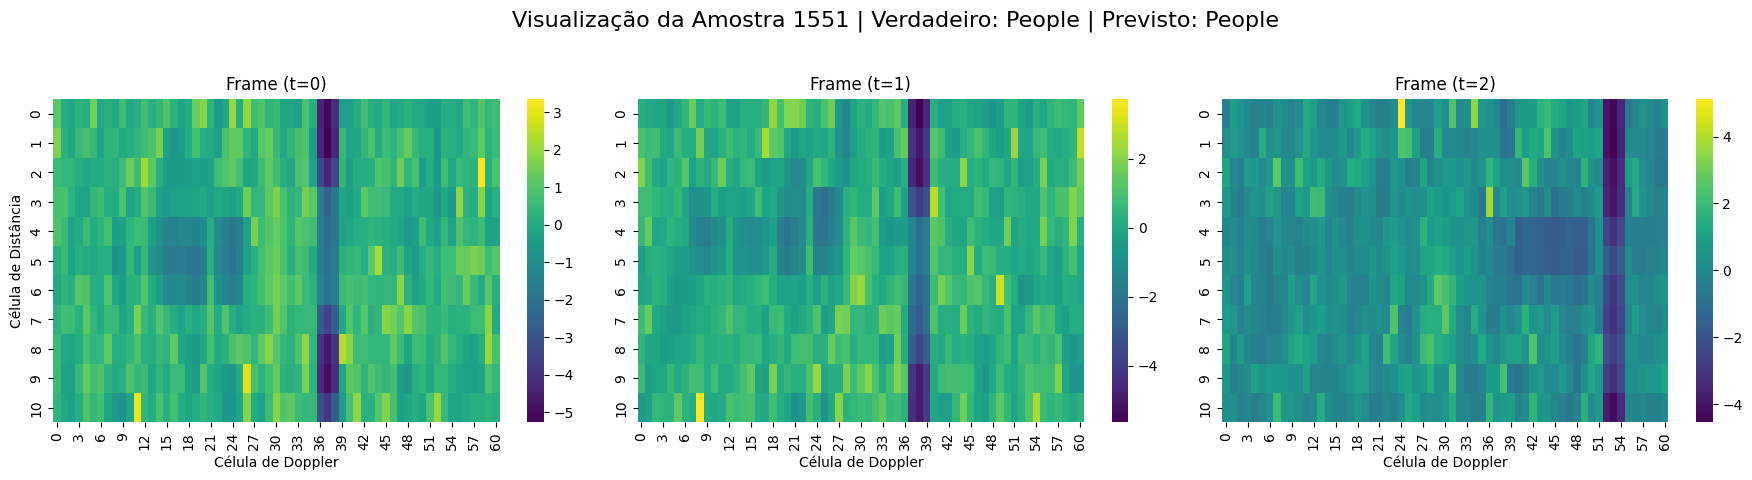



--- AMOSTRA DO CONJUNTO DE TESTE #8 (Índice Original: 101) ---
Classe Verdadeira: Cars
Classe Prevista:   Cars  ---> (CORRETO)
---------------------------------
Confiança do Modelo (Probabilidades):
  - Cars: 97.20%
  - Drones: 1.50%
  - People: 1.30%
---------------------------------


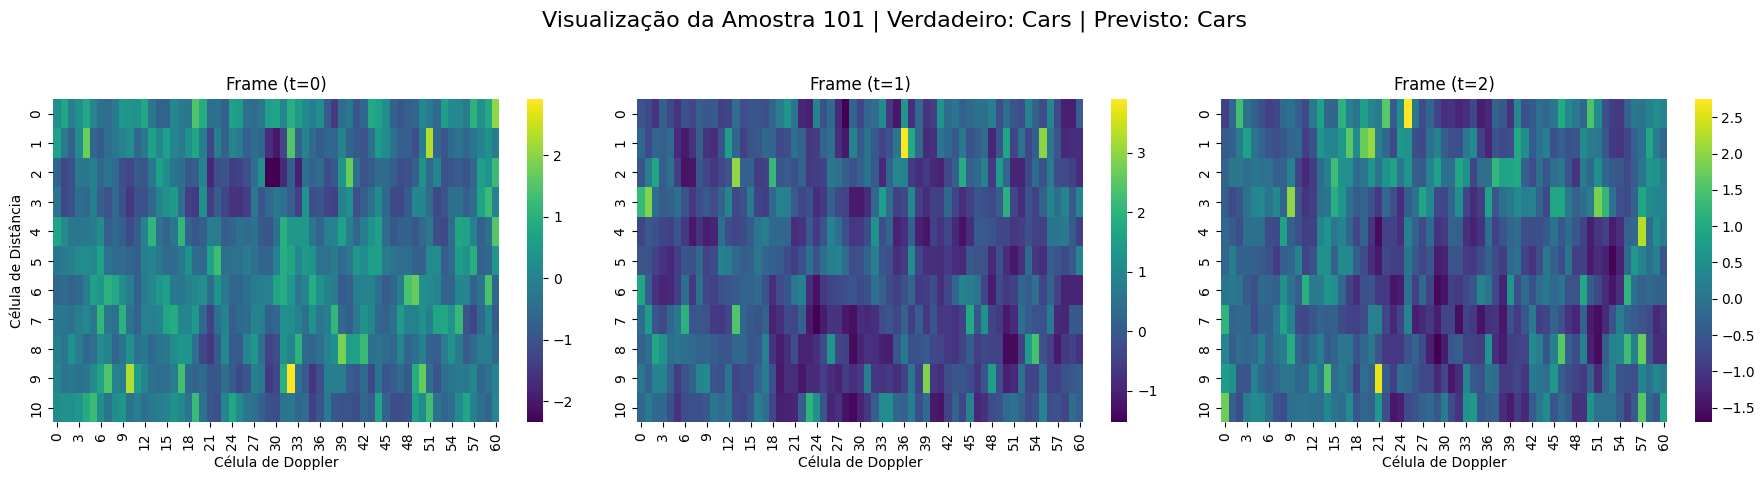



--- AMOSTRA DO CONJUNTO DE TESTE #9 (Índice Original: 1636) ---
Classe Verdadeira: People
Classe Prevista:   Drones  ---> (INCORRETO)
---------------------------------
Confiança do Modelo (Probabilidades):
  - Cars: 1.34%
  - Drones: 95.85%
  - People: 2.81%
---------------------------------


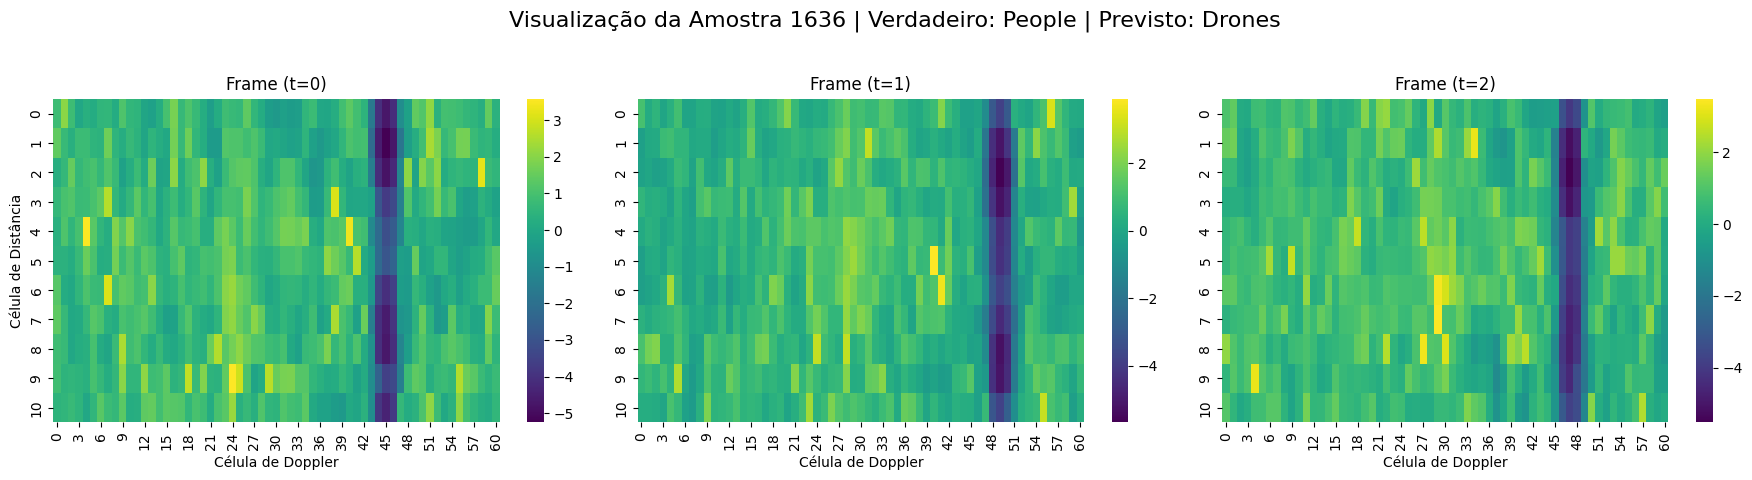



--- AMOSTRA DO CONJUNTO DE TESTE #10 (Índice Original: 1259) ---
Classe Verdadeira: Drones
Classe Prevista:   Drones  ---> (CORRETO)
---------------------------------
Confiança do Modelo (Probabilidades):
  - Cars: 1.27%
  - Drones: 97.16%
  - People: 1.57%
---------------------------------


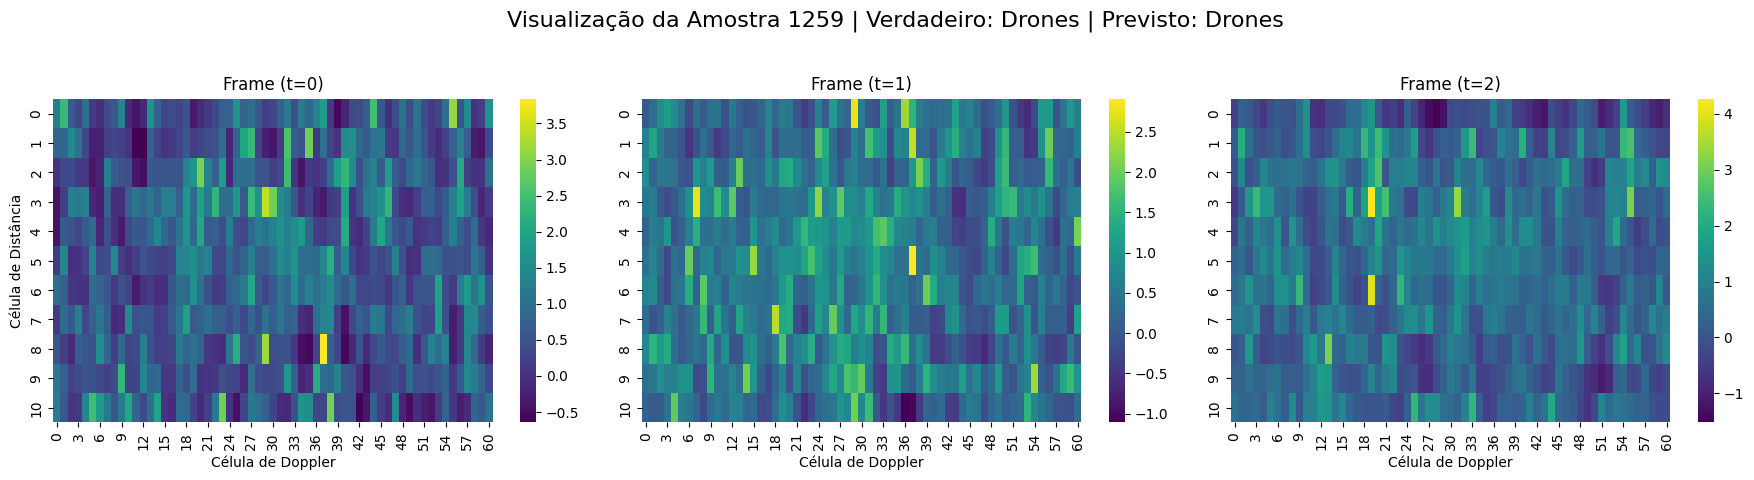

In [ ]:
# Número de amostras aleatórias para visualizar
num_samples_to_show = 10

# Pega índices aleatórios do conjunto de teste
sample_indices = random.sample(range(len(X_test)), num_samples_to_show)

for i, idx in enumerate(sample_indices):
    print(f"\n--- AMOSTRA DO CONJUNTO DE TESTE #{i+1} (Índice Original: {idx}) ---")

    # Pega o dado de entrada (normalizado)
    # O shape é (11, 61, 3)
    sample_data = X_test[idx]

    # Pega o rótulo verdadeiro e o previsto (convertidos para nomes)
    true_label = CLASSES[y_true_test[idx]]
    pred_label = CLASSES[y_pred_test[idx]]

    # Pega as probabilidades (confiança)
    probabilities = predictions_test[idx]

    # Define o status (correto ou incorreto)
    status = "CORRETO" if true_label == pred_label else "INCORRETO"

    #  Impressão dos Dados
    print(f"Classe Verdadeira: {true_label}")
    print(f"Classe Prevista:   {pred_label}  ---> ({status})")
    print("---------------------------------")
    print("Confiança do Modelo (Probabilidades):")
    for j, class_name in enumerate(CLASSES):
        print(f"  - {class_name}: {probabilities[j]*100:.2f}%")
    print("---------------------------------")

    #  Visualização (Heatmaps dos 3 frames)
    # (Plotamos os dados normalizados, que foi o que o modelo realmente viu)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Frame t=0
    sns.heatmap(sample_data[:, :, 0], ax=axes[0], cmap='viridis')
    axes[0].set_title(f'Frame (t=0)')
    axes[0].set_xlabel('Célula de Doppler')
    axes[0].set_ylabel('Célula de Distância')

    # Frame t=1
    sns.heatmap(sample_data[:, :, 1], ax=axes[1], cmap='viridis')
    axes[1].set_title(f'Frame (t=1)')
    axes[1].set_xlabel('Célula de Doppler')

    # Frame t=2
    sns.heatmap(sample_data[:, :, 2], ax=axes[2], cmap='viridis')
    axes[2].set_title(f'Frame (t=2)')
    axes[2].set_xlabel('Célula de Doppler')

    plt.suptitle(f"Visualização da Amostra {idx} | Verdadeiro: {true_label} | Previsto: {pred_label}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print("=================================================================\n")

A capacidade mais evidente do modelo é a sua alta confiança quando ele acerta. Nas 9 das 10 amostras em que o modelo previu corretamente (Amostras 1 a 8 e amostra 10), a confiança (probabilidade) na classe correta foi extremamente alta, sempre acima de 97%. Isso é muito bom, pois, para a grande maioria dos dados, o modelo não está ''em dúvida''. Ele aprendeu a diferenciar claramente as assinaturas de radar das três classes. Nas previsões corretas, a confiança nas classes erradas é mínima, quase sempre na faixa de 1% a 2%.

Considerando as suas limitações, a amostra 9 é o exemplo ideal da principal limitação do modelo desenvolvido. Ele classificou incorretamente uma amostra de Pessoa (People) como Drone. Não obstante, o ponto mais crítico é que o modelo não apenas errou, mas errou com 95.85% de confiança, ou seja, ele estava "certo" de que era um drone.

Isso se encaixa exatamente ao que fois visto no item anterior, em que a classe ''Drones'' foi a que teve a menor precisão (93% no teste, 91% na validação). a baixa precisão significa que o modelo tende a gerar falsos positivos (ou seja, ele classifica outras coisas como Drones, mesmo quando não são), como foi o caso da amostra 9.

# **ITEM 8** - Compare os resultados com os obtidos pelo sistema proposto no trabalho original para avaliar a eficácia do modelo em relação à referência.

Ao comparar os resultados, meu modelo alcançou uma acurácia robusta de 95,8% no conjunto de validação e 95,2% no conjunto de teste final, o qual considero um excelente resultado, provando que o modelo é adequado para tarefas de classificação do tipo proposto.

O artigo de referência, por outro lado, reporta uma acurácia superior, de 99,48%. No entanto, é possível que essa diferença não se deva a alguma falhamodelo deste projeto, mas a ambiguidades significativas no artigo e a uma possível falha metodológica no trabalho original.


A reprodução dos índices mencionados no artigo foi dificultada por informações pouco claras:


- Estrutura da Rede: Houve uma divergência clara entre a arquitetura de rede apresentada na Figura 10 do artigo  (que indicava 32 filtros, resultando em aprox. 1.1M de parâmetros) e a Tabela 5  (que listava cerca de 3,8 milhões de parâmetros). Pesquisando sobre isso, precisei que inferir que a estrutura correta usava 112 filtros na primeira camada (como foi implementado no projeto) para que o volume de parâmetros fosse similar.

- Coleta de Frames: O artigo menciona o uso de 3 frames empilhados, mas não especifica como foram amostrados: se foi usada uma "janela deslizante" com passo de 1 (como neste projeto) ou se foram agrupados de 3 em 3, sem sobreposição.

Especialmente com relação a essa divisão do dataset, é possível que a acurácia de 99,48%  reportada no artigo seja resultado de *data leakage* (vazamento de dados). O artigo menciona "dividir aleatoriamente em cinco sub-datasets" , mas não garante que essa divisão tenha sido feita agrupando-se por experimento (ou seja, garantindo que frames de uma mesma captura não estivessem simultaneamente nos conjuntos de treino e teste).

A implementação realizada neste projeto tratou explicitamente desse problema, separando as amostras de modo a garantir que não houvesse vazamento. A acurácia de 99% pode sugerir que o modelo de referência foi validado com dados que já eram parcialmente conhecidos do treino.

Por fim, pode-se concluir que os resultados obtidos neste projeto foram bastante satisfatórios, além de terem auxiliado a desenvolver a habilidade prática na elaboração de redes neurais e possibilitar tratar de problemas intimamente ligados à disciplina, que é o tratamento de sinais.

# **ITEM 9** - Escolha uma das arquiteturas clássicas de CNN, treinados com a Imagenet. Este modelos podem ser encontrado em: https://keras.io/api/applications/ . Adapte os dados de entrada, se necessário, e verifique o desempenho obtido na classificação utilizando este novo modelo. Compare com o modelo encontrado inicialmente, considerando custo computacional e desempenho.

## Fine-tunning utilizando modelos diferentes: **MobileNetV2**

In [124]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Lambda, InputLayer, Resizing, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import mixed_precision

In [128]:
# Tamanhos alvo para a MobileNetV2
TARGET_H, TARGET_W = 64, 192

# Criando a rede neural (Sequential, em blocos)
model = Sequential()

# bloco 0 — Adaptação da entrada para a MobileNetV2
model.add(InputLayer(input_shape=(11, 61, 3)))
model.add(Resizing(TARGET_H, TARGET_W, interpolation='bilinear'))
model.add(Rescaling(scale=2.0, offset=-1.0))

# bloco 1 — "Espinha" do MobileNetV2
mobilenet_base = MobileNetV2(
    input_shape=(TARGET_H, TARGET_W, 3),
    include_top=False,
    weights=None,
    alpha=0.75,
    pooling=None
)
model.add(mobilenet_base)

# bloco 2
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())

# bloco 3
model.add(Dense(units=128, kernel_initializer='he_normal',kernel_regularizer=l2(l2_rate), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.30))

# bloco 4
model.add(Dense(units=64, kernel_initializer='he_normal',kernel_regularizer=l2(l2_rate), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# bloco 5 — Saída
model.add(Dense(units=num_classes, kernel_initializer='he_normal'))
model.add(Activation('softmax'))

print(model.summary())


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 64, 192, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 64, 192, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.75_64             │ (None, 2, 6, 1280)     │     1,382,064 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │       163,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 3)              │           195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,560,179 (5.95 MB)

 Trainable params: 1,530,595 (5.84 MB)

 Non-trainable params: 29,584 (115.56 KB)

None


In [140]:
# Parâmetros para MobileNetV2
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
opt  = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)

model.compile(optimizer=opt, loss=loss,
              metrics=['accuracy', tf.keras.metrics.CategoricalCrossentropy(name='ce')])

# outros parâmetros de callback
ckpt  = tf.keras.callbacks.ModelCheckpoint('best_mobilenetv2.keras',
                                           monitor='val_loss',
                                           save_best_only=True, verbose=1)

rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                             factor=0.5,
                                             patience=15,
                                             min_lr=1e-5,
                                             verbose=1)

es    = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=20,
                                         restore_best_weights=True,
                                         verbose=1)

In [143]:
# Treino
history_mb = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,            # use o mesmo que já usa
    callbacks=[ckpt, rlrop, es],
    verbose=1
)

Epoch 1/100
204/205 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9994 - ce: 0.0400 - loss: 0.1800
Epoch 1: val_loss did not improve from 0.88298
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9994 - ce: 0.0400 - loss: 0.1800 - val_accuracy: 0.7418 - val_ce: 0.8879 - val_loss: 0.9678 - learning_rate: 2.5000e-04
Epoch 2/100
204/205 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9988 - ce: 0.0410 - loss: 0.1801
Epoch 2: val_loss did not improve from 0.88298
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9988 - ce: 0.0410 - loss: 0.1801 - val_accuracy: 0.6802 - val_ce: 1.1179 - val_loss: 1.1878 - learning_rate: 2.5000e-04
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9992 - ce: 0.0411 - loss: 0.1805
Epoch 3: val_loss did not improve from 0.88298
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9992 - ce: 0.0411 - loss: 0.1805 - val_accuracy: 0.7206 - val_ce: 1.0138 - val_loss: 1.0893 - learning_rate: 2.5000e-04
Epoch 4/100
203/205 ━━━━━━━━

MobileNetV2 — teste:
{'loss': 0.5715851783752441, 'compile_metrics': 0.8484988212585449}


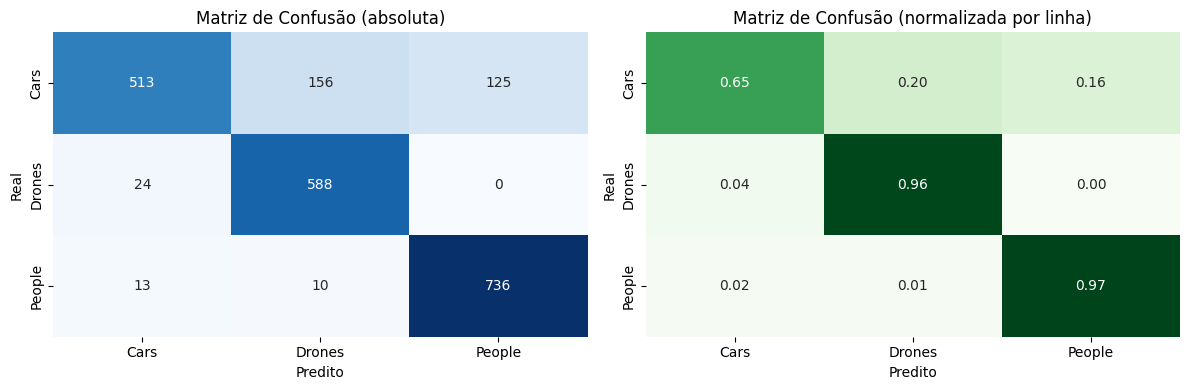


=== Relatório de Métricas ===
              precision  recall  f1-score    support
Cars             0.9327  0.6461    0.7634   794.0000
Drones           0.7798  0.9608    0.8609   612.0000
People           0.8548  0.9697    0.9086   759.0000
accuracy         0.8485  0.8485    0.8485     0.8485
macro avg        0.8558  0.8589    0.8443  2165.0000
weighted avg     0.8622  0.8485    0.8419  2165.0000


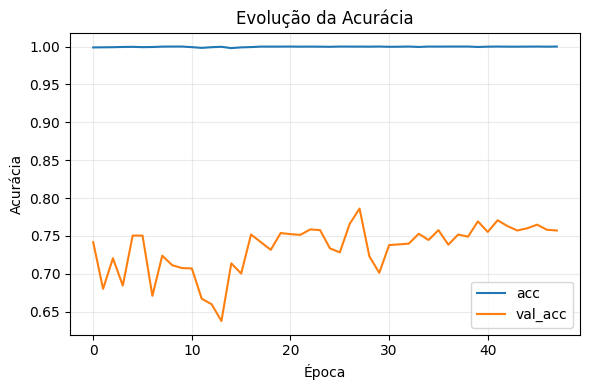

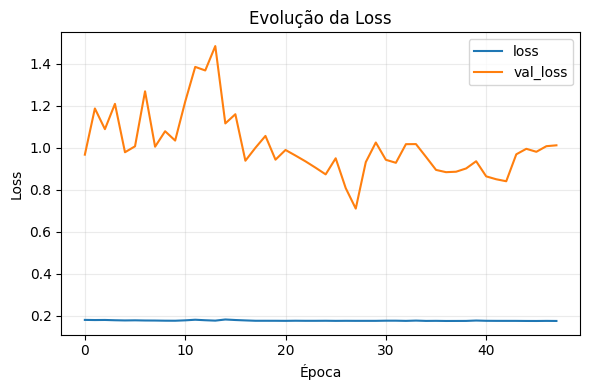

In [144]:
# Avaliação final
print("MobileNetV2 — teste:")
test_metrics_mb = model.evaluate(X_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, test_metrics_mb)))

# ===== Predições =====
y_prob = model.predict(X_test, batch_size=64, verbose=0)
y_pred = y_prob.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# ===== Matriz de confusão =====
labels = CLASSES if 'CLASSES' in globals() else [f'class {i}' for i in range(y_test.shape[1])]

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[0])
axes[0].set_title('Matriz de Confusão (absoluta)')
axes[0].set_xlabel('Predito'); axes[0].set_ylabel('Real')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[1])
axes[1].set_title('Matriz de Confusão (normalizada por linha)')
axes[1].set_xlabel('Predito'); axes[1].set_ylabel('Real')
plt.tight_layout(); plt.show()

# ===== Quadro de métricas =====
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True, digits=4)
report_df = pd.DataFrame(report).transpose()
# Ordena para deixar por classe no topo e agregados ao final
ordem = labels + ['accuracy', 'macro avg', 'weighted avg']
report_df = report_df.reindex(ordem)
print('\n=== Relatório de Métricas ===')
print(report_df[['precision', 'recall', 'f1-score', 'support']].round(4))


# ===== Curvas de treino =====
hist = history_mb.history  # garante que você treinou como 'history_mb = model.fit(...)'
plt.figure(figsize=(6,4))
plt.plot(hist['accuracy'],     label='acc')
plt.plot(hist['val_accuracy'], label='val_acc')
plt.title('Evolução da Acurácia'); plt.xlabel('Época'); plt.ylabel('Acurácia')
plt.legend(); plt.grid(True, alpha=0.25); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist['loss'],     label='loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.title('Evolução da Loss'); plt.xlabel('Época'); plt.ylabel('Loss')
plt.legend(); plt.grid(True, alpha=0.25); plt.tight_layout(); plt.show()


O desempenho do modelo MobileNetV2, resumido pela matriz de confusão, mostra um comportamento assimétrico. Observa-se que as classes "Drones" (recall $\approx$ 0,96) e "People" (recall $\approx$ 0,97) são identificadas com extrema segurança.

Contudo, o ponto fraco do modelo está claramente na classe "Cars": o recall foi significativamente mais baixo ( $\approx$ 0,65), embora a precisão tenha sido muito alta ( $\approx$ 0,93). Em outras palavras, quando o modelo prevê "Car", ele quase sempre acerta, mas falha em identificar cerca de 35% dos carros, confundindo-os principalmente com "Drones" (20%) e "People" (16%). A acurácia global ($\approx$ 0,85) é alta, mas mascara essa deficiência específica.

Os gráficos de treino explicam esse comportamento de forma clara. Há um sinal evidente de overfitting severo: a acurácia de treino (acc) sobe para 100% quase instantaneamente (antes da época 5) e ali permanece, enquanto a acurácia de validação (val_acc) estagna muito abaixo (oscilando entre 0,65 e 0,79). A divergência na perda é ainda mais drástica: a loss de treino cai para um valor mínimo ( $\approx$ 0,2), enquanto a val_loss permanece extremamente alta (flutuando $\approx$ 1,0) e "serrilhada". Essa instabilidade e o alto valor da val_loss sugerem que o modelo está muito confiante em suas predições (memorizando o treino) e que as oscilações podem ser causadas por lotes de validação desbalanceados ou pela instabilidade das camadas de BatchNormalization com o learning rate aplicado.

Com base nisso, é necessário melhorar a estrutura da rede e aplicar técnicas para reduzir o overfitting. Além disso, a técnica de transfer-learning, utilizando pesos pré-treinados dessa rede, pode ser vantajoso e interessante neste caso, a fim de buscar resultados melhores e gráficos menos erráticos.